Sử dụng thiết bị: cuda
Tải dữ liệu thành công.
Epoch 001/100 | Train Loss: 8.2462 | Val Loss: 7.2031
Epoch 002/100 | Train Loss: 7.5286 | Val Loss: 7.1541
Epoch 003/100 | Train Loss: 7.4333 | Val Loss: 7.1041
Epoch 004/100 | Train Loss: 7.4006 | Val Loss: 7.1282
Epoch 005/100 | Train Loss: 7.3853 | Val Loss: 7.0937
Epoch 006/100 | Train Loss: 7.3776 | Val Loss: 7.0857
Epoch 007/100 | Train Loss: 7.3726 | Val Loss: 7.1102
Epoch 008/100 | Train Loss: 7.3683 | Val Loss: 7.1300
Epoch 009/100 | Train Loss: 7.3601 | Val Loss: 7.1143
Epoch 010/100 | Train Loss: 7.3588 | Val Loss: 7.0947
Epoch 011/100 | Train Loss: 7.3510 | Val Loss: 7.1214
Epoch 012/100 | Train Loss: 7.3399 | Val Loss: 7.1272
Epoch 013/100 | Train Loss: 7.3444 | Val Loss: 7.1961
Epoch 014/100 | Train Loss: 7.3469 | Val Loss: 7.0871
Epoch 015/100 | Train Loss: 7.3400 | Val Loss: 7.1297
Epoch 016/100 | Train Loss: 7.3425 | Val Loss: 7.0942
Epoch 017/100 | Train Loss: 7.3377 | Val Loss: 7.0925
Epoch 018/100 | Train Loss: 7.3385 

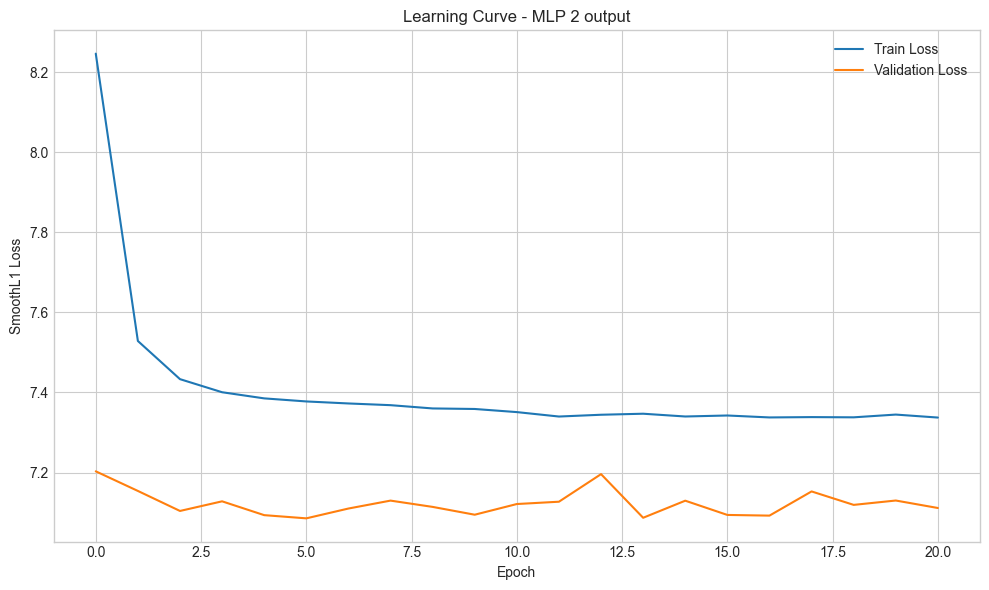


=== Đánh giá trên tập test ===
[weekly_study_hours] MAE: 4.5154 | RMSE: 5.5748 | R²: 0.5904
[attendance_percentage] MAE: 10.6238 | RMSE: 13.5273 | R²: 0.6205


In [8]:
# === PHẦN 0: IMPORT & THIẾT BỊ ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# === PHẦN 1: LOAD DATA ===
data_loaded_successfully = False
try:
    df = pd.read_csv('clean_student_data_v1.csv')
    print("Tải dữ liệu thành công.")
    TARGET_COLUMN = ['weekly_study_hours','attendance_percentage']
    df['raw_score_x_part_time_hours'] = df['raw_score'] * df['part_time_hours']
    df['raw_score_x_financial_support'] = df['raw_score'] * df['financial_support']
    df['raw_score_x_emotional_support'] = df['raw_score'] * df['emotional_support']
    df['raw_score_x_part_time_financial'] = df['raw_score'] * df['part_time_hours'] * df['financial_support']
    DROP_COLUMNS = [
        'weekly_study_hours','attendance_percentage',
        'study_hours_x_attendance',
        'full_interaction_feature',
        'expected_score_hint',
        'student_id', 'year',
        'cumulative_gpa', 'current_semester_gpa',
        'previous_courses_taken', 'previous_credits_earned',
        'expected_difficulty', 'subject_type','fail_rate_general','fail_rate_major','study_hours_x_part_part_time_hours',
        'attendance_x_emotional_support'
    ]
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train_raw.select_dtypes(include=np.number).columns
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)
    data_loaded_successfully = True
except FileNotFoundError:
    print("Không tìm thấy file.")

# === PHẦN 2: MLP 2-OUTPUT + Weighted Loss ===
if data_loaded_successfully:
    # Chuẩn bị dữ liệu
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # shape: (N, 2)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Trọng số: nếu bất kỳ output nào < 5 → weight = 2, ngược lại = 1
    sample_weights = np.where((y_train < 5).any(axis=1), 2.0, 1.0)
    sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float32).reshape(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor, sample_weights_tensor), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]  # = 2

    # === MLP SÂU VÀ 2-OUTPUT ===
    class MLPDeep(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.BatchNorm1d(512),
                nn.SiLU(),
                nn.Dropout(0.3),

                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.SiLU(),
                nn.Dropout(0.3),

                nn.Linear(256, 128),
                nn.SiLU(),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                nn.SiLU(),

                nn.Linear(64, 32),
                nn.SiLU(),

                nn.Linear(32, output_dim)
            )

        def forward(self, x):
            return self.model(x)

    model = MLPDeep(input_dim, output_dim).to(device)
    loss_fn = nn.SmoothL1Loss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    train_losses, val_losses = [], []

    epochs = 100
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for xb, yb, wb in train_loader:
            xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)  # shape: (batch_size, 2)
            loss = loss.mean(dim=1, keepdim=True)  # (batch_size, 1)
            weighted_loss = (loss * wb).mean()

            optimizer.zero_grad()
            weighted_loss.backward()
            optimizer.step()
            total_train_loss += weighted_loss.item() * xb.size(0)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = loss_fn(pred, yb).mean()
                total_val_loss += loss.item() * xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_val_loss = total_val_loss / len(test_loader.dataset)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_mlp_model_2output_2_8_2025.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping tại epoch {epoch+1}")
                break

    # Load lại model tốt nhất
    model.load_state_dict(torch.load("best_mlp_model_2output_2_8_2025.pt"))

    # Biểu đồ loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('SmoothL1 Loss')
    plt.title('Learning Curve - MLP 2 output')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Evaluation ===
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device)).cpu().numpy()

    print("\n=== Đánh giá trên tập test ===")
    for i, target in enumerate(TARGET_COLUMN):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        print(f"[{target}] MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")


def permutation_importance(model, X_tensor, y_tensor, metric=mean_squared_error, n_repeats=5):
    model.eval()
    base_pred = model(X_tensor.to(device)).detach().cpu().numpy()
    base_score = metric(y_tensor.numpy(), base_pred)

    importances = np.zeros(X_tensor.shape[1])

    for col in range(X_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            idx = torch.randperm(X_tensor.shape[0])
            X_permuted[:, col] = X_permuted[idx, col]
            pred = model(X_permuted.to(device)).detach().cpu().numpy()
            score = metric(y_tensor.numpy(), pred)
            scores.append(score - base_score)
        importances[col] = np.mean(scores)
    
    return importances

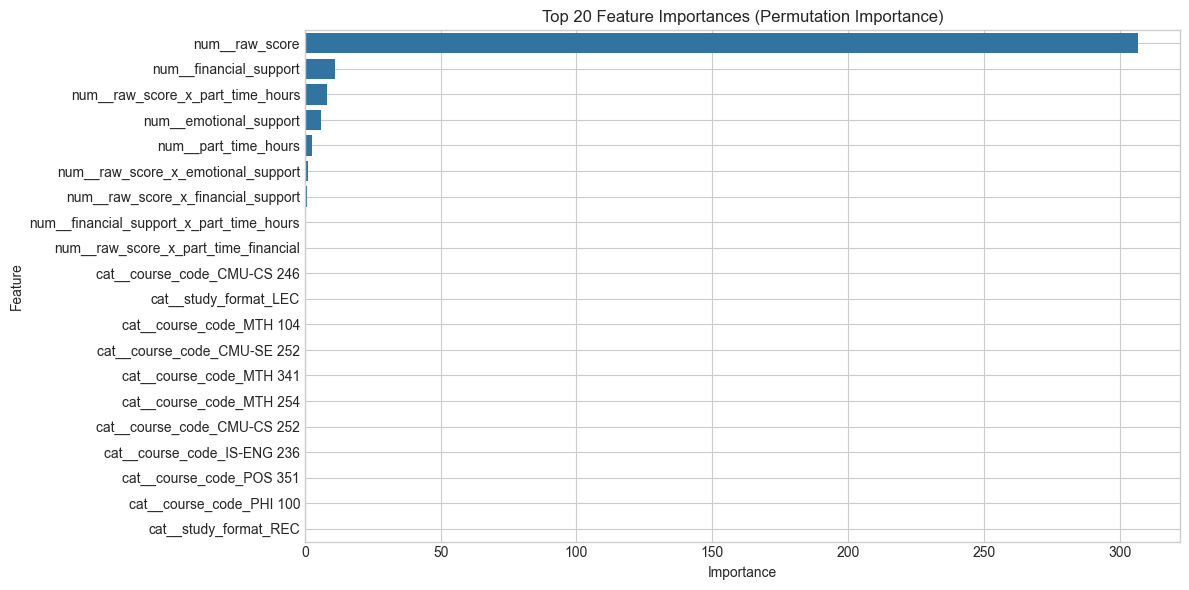

In [9]:
# Tính độ quan trọng
importances = permutation_importance(model, X_test_tensor, y_test_tensor, metric=mean_squared_error, n_repeats=5)
# Lấy tên đặc trưng đã được transform
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Hiển thị top 20 đặc trưng quan trọng nhất
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 20 Feature Importances (Permutation Importance)")
plt.tight_layout()
plt.grid(True)
plt.show()

In [10]:
input_dim = X_train.shape[1]
model = MLPDeep(input_dim, output_dim)
model.load_state_dict(torch.load("best_mlp_model_2output_2_8_2025.pt"))
model.to(device)
model.eval()


MLPDeep(
  (model): Sequential(
    (0): Linear(in_features=74, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SiLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): SiLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): SiLU()
    (13): Linear(in_features=64, out_features=32, bias=True)
    (14): SiLU()
    (15): Linear(in_features=32, out_features=2, bias=True)
  )
)

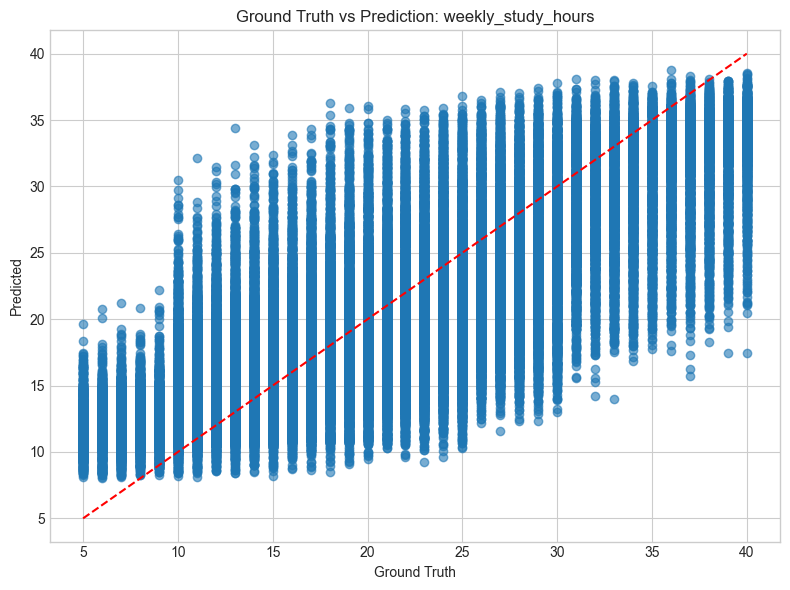

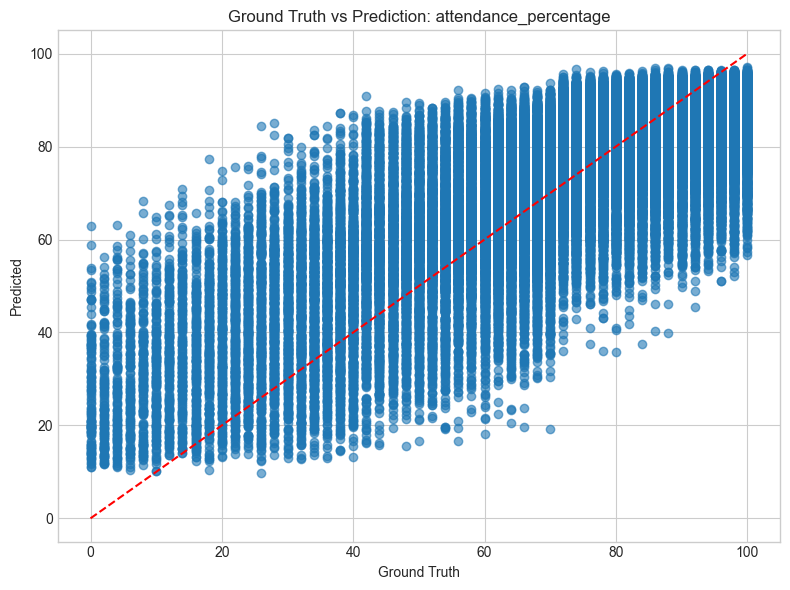

In [11]:
# Giả sử bạn có:
# y_test: numpy array hoặc pandas DataFrame với shape (n_samples, 2)
# y_pred: numpy array với shape (n_samples, 2)

target_names = ['weekly_study_hours', 'attendance_percentage']

for i, target in enumerate(target_names):
    plt.figure(figsize=(8,6))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6)
    min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    plt.title(f'Ground Truth vs Prediction: {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


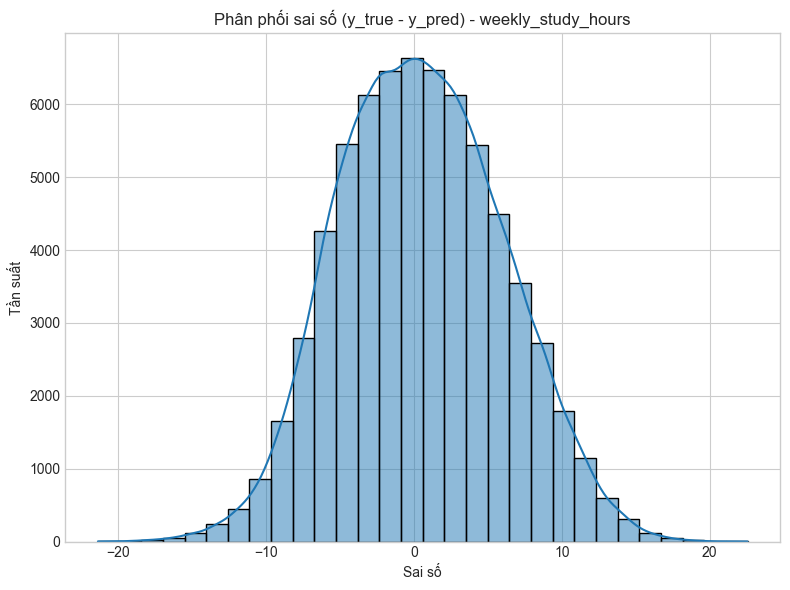

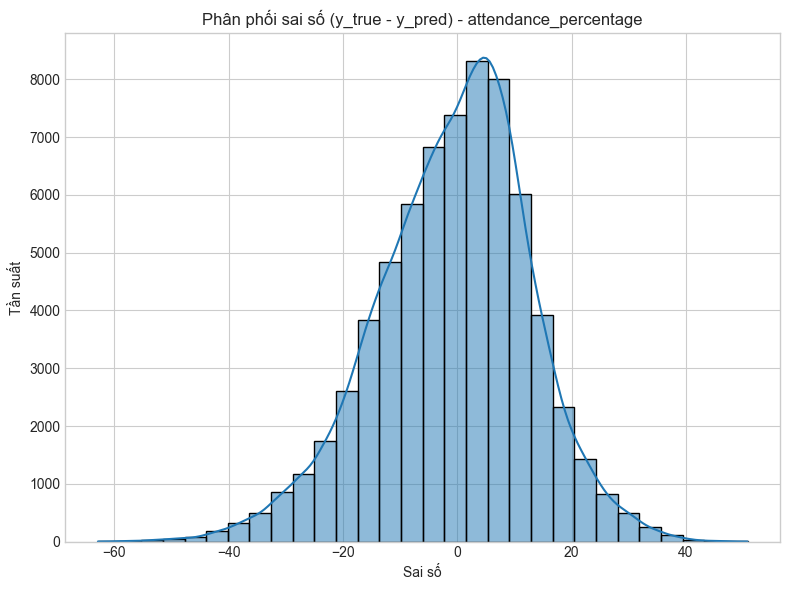

In [12]:
# Giả sử y_test là DataFrame, y_pred là numpy array
target_names = ['weekly_study_hours', 'attendance_percentage']

for i, target in enumerate(target_names):
    errors = y_test.iloc[:, i] - y_pred[:, i]
    plt.figure(figsize=(8,6))
    sns.histplot(errors, bins=30, kde=True)
    plt.title(f"Phân phối sai số (y_true - y_pred) - {target}")
    plt.xlabel("Sai số")
    plt.ylabel("Tần suất")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


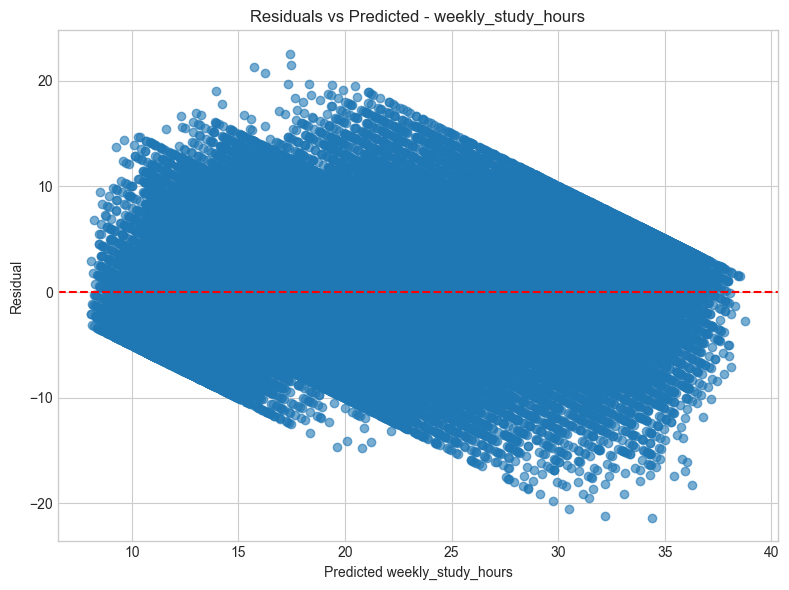

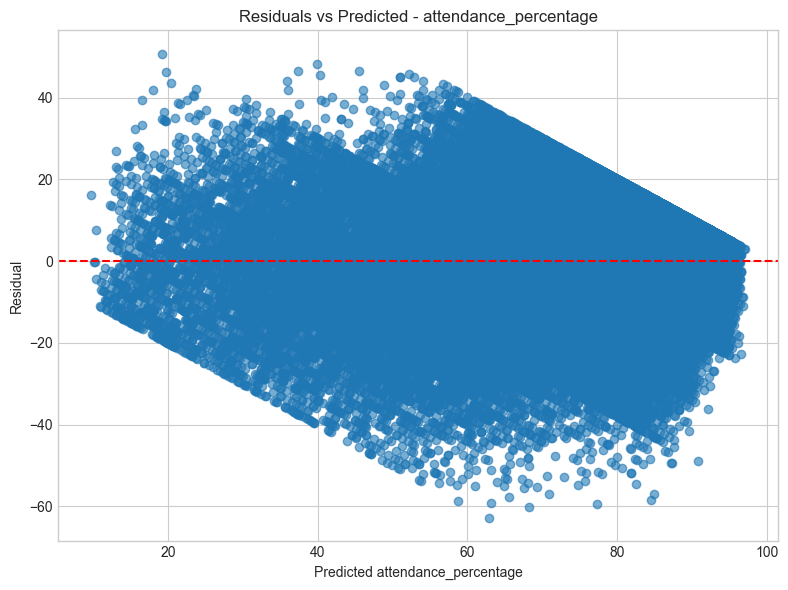

In [13]:
target_names = ['weekly_study_hours', 'attendance_percentage']

for i, target in enumerate(target_names):
    residuals = y_test.iloc[:, i] - y_pred[:, i]
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred[:, i], residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(f'Predicted {target}')
    plt.ylabel('Residual')
    plt.title(f'Residuals vs Predicted - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
